In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
from pathlib import Path
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import re
import numpy as np

# Helper functions

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [4]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()
            
def apply_cats(df, trn):
    """Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values. The category codes are determined by trn.
    trn: A pandas dataframe. When creating a category for df, it looks up the
        what the category's code were in trn and makes those the category codes
        for df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category {a : 1, b : 2}
    >>> df2 = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['b', 'a', 'a']})
    >>> apply_cats(df2, df)
           col1 col2
        0     1    b
        1     2    a
        2     3    a
    now the type of col is category {a : 1, b : 2}
    """
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)
            
def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.
    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.
    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> numericalize(df, df['col2'], 'col3', None)
       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1
        
def fix_missing(df, col, name, na_dict, add_na_columns=True):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    Parameters:
    -----------
    df: The data frame that will be changed.
    col: The column of data to fix by filling in missing data.
    name: The name of the new filled column in df.
    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if na_dict is None: na_dict = {}
        
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            if add_na_columns:
                df[name+'_na'] = pd.isnull(col)
            #filler = na_dict[name] if name in na_dict else col.median()
            filler = 0
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def add_datepart(df, fldnames, drop=True, time=False, errors="raise", attr=None):
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string or list of strings that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    >>>df2 = pd.DataFrame({'start_date' : pd.to_datetime(['3/11/2000','3/13/2000','3/15/2000']),
                            'end_date':pd.to_datetime(['3/17/2000','3/18/2000','4/1/2000'],infer_datetime_format=True)})
    >>>df2
        start_date	end_date    
    0	2000-03-11	2000-03-17
    1	2000-03-13	2000-03-18
    2	2000-03-15	2000-04-01
    >>>add_datepart(df2,['start_date','end_date'])
    >>>df2
    	start_Year	start_Month	start_Week	start_Day	start_Dayofweek	start_Dayofyear	start_Is_month_end	start_Is_month_start	start_Is_quarter_end	start_Is_quarter_start	start_Is_year_end	start_Is_year_start	start_Elapsed	end_Year	end_Month	end_Week	end_Day	end_Dayofweek	end_Dayofyear	end_Is_month_end	end_Is_month_start	end_Is_quarter_end	end_Is_quarter_start	end_Is_year_end	end_Is_year_start	end_Elapsed
    0	2000	    3	        10	        11	        5	            71	            False	            False	                False	                False	                False	            False	            952732800	    2000	    3	        11	        17	    4	            77	            False	            False	            False	            False	                False	        False	            953251200
    1	2000	    3	        11	        13	        0	            73	            False	            False	                False	                False               	False           	False           	952905600     	2000       	3	        11      	18  	5           	78          	False	            False           	False           	False               	False          	False           	953337600
    2	2000	    3	        11	        15	        2           	75          	False           	False               	False               	False               	False               False           	953078400      	2000    	4          	13      	1   	5           	92          	False           	True            	False           	True                	False          	False           	954547200
    """
    if isinstance(fldnames,str): 
        fldnames = [fldnames]
    for fldname in fldnames:
        fld = df[fldname]
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64

        if not np.issubdtype(fld_dtype, np.datetime64):
            df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
        targ_pre = re.sub('[Dd]ate$', '', fldname)
        
        if not attr:
            attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                    'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
            if time: attr = attr + ['Hour', 'Minute', 'Second']
                
        for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
        if not attr:
            df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
        if drop: df.drop(fldname, axis=1, inplace=True)

# Loading data

In [5]:
#basedir = Path("D:\Data\OPAP\Split_by_date")
#basedir = Path("D:\Data\OPAP\Split_by_agents")
# trainfile = "training.csv"
# validationfile = "validation.csv"

basedir = Path("D:\Data\OPAP")
combined = "combined_df.csv"

In [6]:
data = pd.read_csv(basedir / combined)
display_all(data.head().T)

,0,1,2,3,4
AGENT_ID,110008,110008,110008,110008,110008
Pay_Date,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01
Due_Date,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01
RefDate,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01
Payments_Tot,31714.4,25251.9,32771.9,38511.9,36019.9
Settlements_Tot,35862.6,31279.6,30558.3,38305.9,38180.4
Payoff,0.884332,0.807296,1.07244,1.00538,0.943413
Weighted_Days,-2.49502,-2.4094,-2.42292,-2.48137,-2.44134
Weighted_Rank,1.06535,1.08207,1,1,1
Average_Rank,1.04348,1.04545,1,1,1


In [35]:
#Same agent_id in both datasets?
train.set_index('AGENT_ID').join(validation.set_index('AGENT_ID'), lsuffix='_l', rsuffix='_r', how='inner').reset_index()

,AGENT_ID,Pay_Date_l,Due_Date_l,RefDate_l,Payments_Tot_l,Settlements_Tot_l,Payoff_l,Weighted_Days_l,Weighted_Rank_l,Average_Rank_l,...,RefDay_r,RefDayofweek_r,RefDayofyear_r,RefIs_month_end_r,RefIs_month_start_r,RefIs_quarter_end_r,RefIs_quarter_start_r,RefIs_year_end_r,RefIs_year_start_r,RefElapsed_r
0,110008,2018-06-01,2018-06-01,2018-09-01 00:00:00+00:00,31714.42,35862.57,0.884332,-2.495023,1.065349,1.043478,...,1,0,182,False,True,False,True,False,False,1561939200
1,110008,2018-06-01,2018-06-01,2018-09-01 00:00:00+00:00,31714.42,35862.57,0.884332,-2.495023,1.065349,1.043478,...,1,3,213,False,True,False,False,False,False,1564617600
2,110008,2018-07-01,2018-07-01,2018-10-01 00:00:00+00:00,25251.87,31279.55,0.807296,-2.409395,1.082073,1.045455,...,1,0,182,False,True,False,True,False,False,1561939200
3,110008,2018-07-01,2018-07-01,2018-10-01 00:00:00+00:00,25251.87,31279.55,0.807296,-2.409395,1.082073,1.045455,...,1,3,213,False,True,False,False,False,False,1564617600
4,110008,2018-08-01,2018-08-01,2018-11-01 00:00:00+00:00,32771.91,30558.29,1.072439,-2.422921,1.000000,1.000000,...,1,0,182,False,True,False,True,False,False,1561939200
5,110008,2018-08-01,2018-08-01,2018-11-01 00:00:00+00:00,32771.91,30558.29,1.072439,-2.422921,1.000000,1.000000,...,1,3,213,False,True,False,False,False,False,1564617600
6,110008,2018-09-01,2018-09-01,2018-12-01 00:00:00+00:00,38511.87,38305.91,1.005377,-2.481374,1.000000,1.000000,...,1,0,182,False,True,False,True,False,False,1561939200
7,110008,2018-09-01,2018-09-01,2018-12-01 00:00:00+00:00,38511.87,38305.91,1.005377,-2.481374,1.000000,1.000000,...,1,3,213,False,True,False,False,False,False,1564617600
8,110008,2018-10-01,2018-10-01,2019-01-01 00:00:00+00:00,36019.93,38180.45,0.943413,-2.441340,1.000000,1.000000,...,1,0,182,False,True,False,True,False,False,1561939200
9,110008,2018-10-01,2018-10-01,2019-01-01 00:00:00+00:00,36019.93,38180.45,0.943413,-2.441340,1.000000,1.000000,...,1,3,213,False,True,False,False,False,False,1564617600


In [36]:
#train.query('AGENT_ID=="110008"')
validation.query('AGENT_ID=="110008"')

,AGENT_ID,Pay_Date,Due_Date,RefDate,Payments_Tot,Settlements_Tot,Payoff,Weighted_Days,Weighted_Rank,Average_Rank,...,RefDay,RefDayofweek,RefDayofyear,RefIs_month_end,RefIs_month_start,RefIs_quarter_end,RefIs_quarter_start,RefIs_year_end,RefIs_year_start,RefElapsed
0,110008,2019-04-01,2019-04-01,2019-07-01 00:00:00+00:00,1804.29,43778.71,0.041214,0.0,1.0,1.0,...,1,0,182,False,True,False,True,False,False,1561939200
1,110008,2019-07-01,2019-05-01,2019-08-01 00:00:00+00:00,1979.57,44788.46,0.044198,0.0,1.0,1.0,...,1,3,213,False,True,False,False,False,False,1564617600


In [37]:
#train.head().T
train[['RefDate','label']].describe(include='all')

,RefDate,label
count,76236,76236.000000
unique,10,NaN
top,2019-06-01 00:00:00+00:00,NaN
freq,11667,NaN
first,2018-09-01 00:00:00+00:00,NaN
last,2019-06-01 00:00:00+00:00,NaN
mean,NaN,0.499843
std,NaN,0.500003
min,NaN,0.000000
25%,NaN,0.000000


In [38]:
validation[['RefDate','label']].describe(include='all')

,RefDate,label
count,7619,7619.000000
unique,2,NaN
top,2019-07-01 00:00:00+00:00,NaN
freq,3813,NaN
first,2019-07-01 00:00:00+00:00,NaN
last,2019-08-01 00:00:00+00:00,NaN
mean,NaN,0.006694
std,NaN,0.081547
min,NaN,0.000000
25%,NaN,0.000000


In [39]:
X.head()

,AGENT_ID,Payments_Tot,Settlements_Tot,Payoff,Weighted_Days,Weighted_Rank,Average_Rank,TOTAL_PAYMENTS_AMOUNT_PERC,TOTAL_SLIPS_PAYMENTS_PERC,AMOUNT_PLAYED_LIVE_OTC_PERC,...,RefDay,RefDayofweek,RefDayofyear,RefIs_month_end,RefIs_month_start,RefIs_quarter_end,RefIs_quarter_start,RefIs_year_end,RefIs_year_start,RefElapsed
0,110008,31714.42,35862.57,0.884332,-2.495023,1.065349,1.043478,0.476921,0.259271,0.010187,...,1,5,244,False,True,False,False,False,False,1535760000
1,110008,25251.87,31279.55,0.807296,-2.409395,1.082073,1.045455,0.708441,0.283358,0.005999,...,1,0,274,False,True,False,True,False,False,1538352000
2,110008,32771.91,30558.29,1.072439,-2.422921,1.000000,1.000000,0.670639,0.279919,0.003893,...,1,3,305,False,True,False,False,False,False,1541030400
3,110008,38511.87,38305.91,1.005377,-2.481374,1.000000,1.000000,0.724181,0.300459,0.005703,...,1,5,335,False,True,False,False,False,False,1543622400
4,110008,36019.93,38180.45,0.943413,-2.441340,1.000000,1.000000,0.668279,0.301955,0.019712,...,1,1,1,False,True,False,True,False,True,1546300800


In [40]:
train[train.label == 1].shape, train[train.label == 0].shape

((38106, 91), (38130, 91))

In [41]:
train[train.PRIOR == 1].shape, train[train.PRIOR == 2].shape, train[train.PRIOR == 3].shape, train[train.PRIOR == 0].shape

((11680, 91), (13140, 91), (13286, 91), (38130, 91))

In [42]:
validation.shape[0], \
validation[validation.PRIOR == 1].shape[0], \
validation[validation.PRIOR == 2].shape[0], \
validation[validation.PRIOR == 3].shape[0], \
validation[validation.PRIOR == 0].shape[0]

(7619, 35, 16, 0, 7568)

In [43]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [258]:
display_all(X.head().T)

,0,1,2,3,4
RefDate,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01
Payments_Tot,31714.4,25251.9,32771.9,38511.9,36019.9
Settlements_Tot,35862.6,31279.6,30558.3,38305.9,38180.4
Payoff,0.884332,0.807296,1.07244,1.00538,0.943413
Weighted_Days,-2.49502,-2.4094,-2.42292,-2.48137,-2.44134
Weighted_Rank,1.06535,1.08207,1,1,1
Average_Rank,1.04348,1.04545,1,1,1
label,0,0,0,0,0
CATEGORY_Major,0,0,0,0,0
CATEGORY_No Certif-Never checked,1,1,1,1,1


In [52]:
eps = 10e-8
def process_df(df):
    for col in df.columns:
        if col[-5:] == "_PERC":
            df[col] = df[col].apply(lambda x: np.log(x+eps))
        
process_df(X)
process_df(X_valid)

# Processing

In [7]:
#add_datepart(data, 'RefDate', drop=False, attr=['Year', 'Month'])
add_datepart(data, 'FIRST_HL_ACTIVATION_DT', drop=False, attr=['Year'])


cols_to_drop = ['Pay_Date','Due_Date', 'REF_DATE', 'AGENT','PRIOR', 'Default', \
                'LAST_PLAY_DATE_FORMAT', 'Reference_Last_Play_Date','STATUS_NAME','PARENT_STATUS_NAME', \
               'NEW_CONTRACT_DT','SSBT_ACT_DATE','VLT_ACT_DATE','VLT_CURRENT_STATUS','ACT_DT',
               'FIRST_HL_ACTIVATION_DT','VLT_DE_ACT_DATE','LAST_MOVE_DATE','AGENT_ID','RET_CD',
               'LONGITUDE','LATITUDE','LATEST_CHANGE', 'TERMINAL_STATUS', 'OPERATING_STATUS','LEGAL_TYPE_NAME']

additional_to_drop = ['REGION','MUNICIPALITY','AREA_SIZE_MEASURED','Nomos','Province_Population', \
'Municipality_Population','Municipality_Population_KAP','City_Population','GDP_per_Capita', \
'OPAP_LIMIT','HL_LIMIT','BET_LIMIT','ODIE_LIMIT']
# CITY, CLASS remain

#cols_to_drop = cols_to_drop + additional_to_drop

for col in data.columns:
    if str(col).endswith('_PERC') or str(col).endswith('_Tot'):
        cols_to_drop += [col]


X = data.drop(cols_to_drop, axis=1)
y = data.label

X['RefDate'].describe().T

count          46010
unique            12
top       2019-01-01
freq            3885
Name: RefDate, dtype: object

In [8]:
missing_values_replace={}
for n,c in X.items(): na_dict = fix_missing(X, c, n, missing_values_replace, add_na_columns=False)
    
cols_to_numeric = ['MUNICIPALITY','Nomos','CITY','CLASS','LEGAL_TYPE_NAME','REGION', \
                   'TERMINAL_STATUS','OPERATING_STATUS','LATEST_CHANGE']

cols_to_numeric = [x for x in cols_to_numeric if x in X.columns]

for n,c in X[cols_to_numeric].items():
    numericalize(X, c, n, None)

y_train = X.query("RefDate<'2019-07-01'").label
y_valid = X.query("RefDate>='2019-07-01'").label
X_train = X.query("RefDate<'2019-07-01'").drop(['RefDate','label'], axis=1)
X_valid = X.query("RefDate>='2019-07-01'").drop(['RefDate','label'], axis=1)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((38391, 25), (7619, 25), (38391,), (7619,))

In [418]:
X.head()

,RefDate,Payoff,Weighted_Days,Weighted_Rank,Average_Rank,label,CATEGORY_Major,CATEGORY_No Certif-Never checked,CATEGORY_Significant,RESTRUCTURINGS,...,Municipality_Population,Municipality_Population_KAP,City_Population,GDP_per_Capita,CLASS,OPAP_LIMIT,HL_LIMIT,BET_LIMIT,ODIE_LIMIT,FIRST_HL_ACTIVATION_DTYear
0,2018-09-01,0.884332,-2.495023,1.065349,1.043478,0,0.0,1.0,0.0,0.0,...,745514.0,745514.0,745514.0,23122.82,1,7500.0,12000.0,1000.0,0.0,2014.0
1,2018-10-01,0.807296,-2.409395,1.082073,1.045455,0,0.0,1.0,0.0,0.0,...,745514.0,745514.0,745514.0,23122.82,1,7500.0,12000.0,1000.0,0.0,2014.0
2,2018-11-01,1.072439,-2.422921,1.000000,1.000000,0,0.0,1.0,0.0,0.0,...,745514.0,745514.0,745514.0,23122.82,1,7500.0,12000.0,1000.0,0.0,2014.0
3,2018-12-01,1.005377,-2.481374,1.000000,1.000000,0,0.0,1.0,0.0,0.0,...,745514.0,745514.0,745514.0,23122.82,1,7500.0,12000.0,1000.0,0.0,2014.0
4,2019-01-01,0.943413,-2.441340,1.000000,1.000000,0,0.0,1.0,0.0,0.0,...,745514.0,745514.0,745514.0,23122.82,1,7500.0,12000.0,1000.0,0.0,2014.0


In [9]:
colname = 'CLASS'

print(X.groupby(colname)[colname].count())

print(X.CLASS.astype('category').cat.categories)

print(f'Empty values of {colname}: ', X[colname].isna().sum())

CLASS
A       36621
A-         90
B        1669
B-         36
C         797
C+          7
C-         22
D        2542
None      461
Name: CLASS, dtype: int64
Index(['A', 'A-', 'B', 'B-', 'C', 'C+', 'C-', 'D', 'None'], dtype='object')
Empty values of CLASS:  3765


In [24]:
colname = 'CITY'

print(X.groupby(colname)[colname].count().head(20))
print('----')
print(X.CLASS.astype('category').cat.categories[:10])

CITY
Άβδηρα,τα / ΝΟΜΟΣ ΞΑΝΘΗΣ                                 12
Άγιοι Ανάργυροι,οι / ΑΤΤΙΚΗ                             192
Άγιοι Απόστολοι,οι / ΑΤΤΙΚΗ                              12
Άγιοι Δέκα,οι / ΝΟΜΟΣ ΗΡΑΚΛΕΙΟΥ                          12
Άγιοι Θεόδωροι,οι / ΝΟΜΟΣ ΚΟΡΙΝΘΙΑΣ                      36
Άγιος Αθανάσιος,ο / ΝΟΜΟΣ ΔΡΑΜΑΣ                         13
Άγιος Αθανάσιος,ο / ΝΟΜΟΣ ΘΕΣΣΑΛΟΝΙΚΗΣ                   24
Άγιος Ανδρέας,ο / ΝΟΜΟΣ ΑΡΚΑΔΙΑΣ                         12
Άγιος Γεώργιος,ο / ΝΟΜΟΣ ΗΜΑΘΙΑΣ                         12
Άγιος Δημήτριος,ο / ΑΤΤΙΚΗ                              274
Άγιος Δημήτριος,ο / ΝΟΜΟΣ ΑΡΤΗΣ                          12
Άγιος Ιωάννης Ρέντης,ο / ΑΤΤΙΚΗ                          72
Άγιος Κωνσταντίνος,ο / ΝΟΜΟΣ ΑΙΤΩΛΙΑΣ ΚΑΙ ΑΚΑΡΝΑΝΙΑΣ     12
Άγιος Κωνσταντίνος,ο / ΝΟΜΟΣ ΦΘΙΩΤΙΔΟΣ                   12
Άγιος Νικόλαος,ο / ΝΟΜΟΣ ΕΥΒΟΙΑΣ                          6
Άγιος Νικόλαος,ο / ΝΟΜΟΣ ΛΑΣΙΘΙΟΥ                        48
Άγιος Νικόλαος,ο / ΝΟΜΟΣ ΧΑΛΚΙΔΙΚΗΣ

In [422]:
X.query('AGENT_ID=="110011"')[['AGENT_ID','CLASS']]

,AGENT_ID,CLASS
24,110011,NaN
25,110011,NaN
26,110011,NaN
27,110011,NaN
28,110011,NaN
29,110011,NaN
30,110011,NaN
31,110011,NaN
32,110011,NaN
33,110011,NaN


In [432]:
for _, row in X.dtypes.reset_index().iterrows():
    if row[0] not in ['float64','int64','int16','int8','bool']:
        print(row['index'], row[0])
    #print(row['index'], row['0'])

RefDate datetime64[ns]
REGION object
MUNICIPALITY object
Nomos object
CITY object
CLASS object
LEGAL_TYPE_NAME object
LATEST_CHANGE object
TERMINAL_STATUS object
OPERATING_STATUS object


In [ ]:
X[['AGENT_ID','RefDate','Payments_Tot','Nomos','label']].head(), X_train[['AGENT_ID','Payments_Tot','Nomos']].head(), y_train.head()

In [ ]:
display_all(X.head().T)

In [265]:
display_all(X_train.head().T)

,0,1,2,3,4
Payments_Tot,3.171442e+04,2.525187e+04,3.277191e+04,3.851187e+04,3.601993e+04
Settlements_Tot,3.586257e+04,3.127955e+04,3.055829e+04,3.830591e+04,3.818045e+04
Payoff,8.843320e-01,8.072965e-01,1.072439e+00,1.005377e+00,9.434129e-01
Weighted_Days,-2.495023e+00,-2.409395e+00,-2.422921e+00,-2.481374e+00,-2.441340e+00
Weighted_Rank,1.065349e+00,1.082073e+00,1.000000e+00,1.000000e+00,1.000000e+00
Average_Rank,1.043478e+00,1.045455e+00,1.000000e+00,1.000000e+00,1.000000e+00
CATEGORY_Major,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
CATEGORY_No Certif-Never checked,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
CATEGORY_Significant,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
RESTRUCTURINGS,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


# Fitting

In [151]:
def fit(max_depth=None, n_estimators=100, bootstrap=True, min_samples_leaf=2, max_features='auto', \
        max_samples=None, class_weight="balanced_subsample", X=X_train, y=y_train):
    
    m = RandomForestClassifier(n_jobs=-1, max_depth=max_depth, n_estimators=n_estimators,
                               bootstrap=bootstrap, oob_score=True, min_samples_leaf = min_samples_leaf,
                               max_features=max_features, max_samples=max_samples,
                               class_weight=class_weight)    
    m.fit(X, y)
    return m

Fit and present results

In [125]:
print('Training:', y_train.shape, y_train[y_train==1].shape)
print('Validation:', y_valid.shape, y_valid[y_valid==1].shape)

Training: (38391,) (261,)
Validation: (7619,) (51,)


In [11]:
unbalanced_ratio = y_train[y_train==1].shape[0] / y_train.shape[0]
unbalanced_ratio

0.006798468391029148

In [173]:
#%%time
class_weight = {0:1, 1:1/unbalanced_ratio}
m = fit(min_samples_leaf=15, max_features=0.5, n_estimators=100, max_samples=0.6, class_weight=class_weight, X=X_train)
preds = m.predict(X_train)
print(f'In training dataset -> Precision: {precision_score(y_train,preds)}, Recall: {recall_score(y_train,preds)}')

In training dataset -> Precision: 0.35919540229885055, Recall: 0.9578544061302682


In [174]:
#Train dataset
preds = m.predict(X_train)
conf_matrix = confusion_matrix(y_train, preds)
conf_matrix

array([[37684,   446],
       [   11,   250]], dtype=int64)

In [175]:
#Validation dataset
preds = m.predict(X_valid)
conf_matrix = confusion_matrix(y_valid, preds)
conf_matrix

array([[7511,   57],
       [  21,   30]], dtype=int64)

In [176]:
preds = m.predict(X_valid)
print(f'Precision: {precision_score(y_valid,preds)}, Recall: {recall_score(y_valid,preds)}')
mistakes = X_valid.copy()
mistakes['label'] = y_valid
mistakes['prediction'] = preds
mistakes = mistakes[preds!=y_valid]
print(f'Mistakes: {len(mistakes)}')
print(f'False negatives: {mistakes.query("label==1").count()["prediction"]}')
#mistakes.query("label==1").groupby('PRIOR').count()['prediction']

Precision: 0.3448275862068966, Recall: 0.5882352941176471
Mistakes: 78
False negatives: 21


In [539]:
#importance = np.sort(m.feature_importances_)[::-1]
#features = X_train.columns
importance = zip(X_train.columns, m.feature_importances_)
fi = []
for col, imp in list(importance):
    fi.append([col, imp])
    
fi = pd.DataFrame(fi, columns=['colname','importance']).sort_values(by=['importance'], ascending=False)
fi.head(30)
   #print(f'{features[i]}: Score: {v:.5f}')

,colname,importance
2,Weighted_Rank,0.084325
0,Payoff,0.031958
1,Weighted_Days,0.029408
3,Average_Rank,0.027486
24,FIRST_HL_ACTIVATION_DTYear,0.023143
22,BET_LIMIT,0.021307
9,REGION,0.018638
4,CATEGORY_Major,0.011557
5,CATEGORY_No Certif-Never checked,0.009050
13,CITY,0.005505


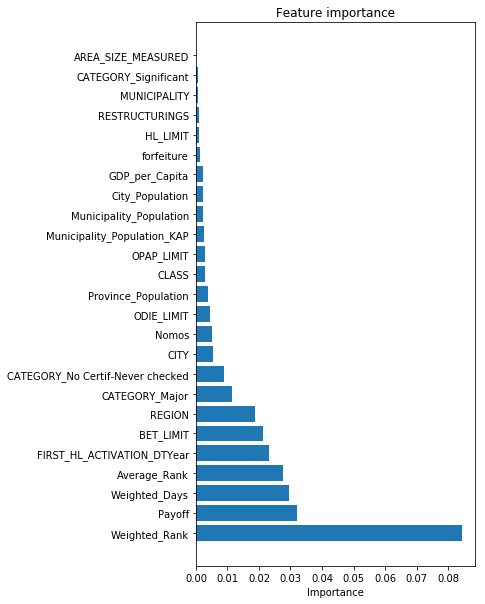

In [540]:
#fi.plot('colname','importance','barh')

fig, ax = plt.subplots(figsize=(5, 10))
ax.barh(fi.head(30)['colname'],fi.head(30)['importance'])
#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importance')
ax.set_title('Feature importance')
plt.show()

In [897]:
cols_to_keep=list(fi.query("importance>0.001")['colname'])
print("Columns to keep: ", len(cols_to_keep))
print(cols_to_keep)

Columns to keep:  30
['Payments_Tot', 'Settlements_Tot', 'Payoff', 'Weighted_Days', 'Weighted_Rank', 'Average_Rank', 'TOTAL_PAYMENTS_AMOUNT_PERC', 'TOTAL_SLIPS_PAYMENTS_PERC', 'AMOUNT_PLAYED_LIVE_OTC_PERC', 'SLIPS_PLAYED_LIVE_OTC_PERC', 'PAYMENTS_AMOUNT_LIVE_OTC_MONTHLY_PERC', 'PAYMENTS_AMOUNT_LIVE_OTC_GAME_PERC', 'SLIPS_PAYMENTS_LIVE_OTC_MONTHLY_PERC', 'SLIPS_PAYMENTS_LIVE_OTC_GAME_PERC', 'PAYMENTS_AMOUNT_VOUCHERS_LIVE_OTC_PERC', 'PAID_VOUCHERS_LIVE_OTC_PERC', 'AMOUNT_PLAYED_PREGAME_OTC_PERC', 'SLIPS_PLAYED_PREGAME_OTC_PERC', 'PAYMENTS_AMOUNT_PREGAME_OTC_MONTHLY_PERC', 'PAYMENTS_AMOUNT_PREGAME_OTC_GAME_PERC', 'SLIPS_PAYMENTS_PREGAME_OTC_MONTHLY_PERC', 'SLIPS_PAYMENTS_PREGAME_OTC_GAME_PERC', 'PAYMENTS_AMOUNT_VOUCHERS_PREGAME_OTC_PERC', 'PAID_VOUCHERS_PREGAME_OTC_PERC', 'AMOUNT_PLAYED_MIXED_OTC_PERC', 'SLIPS_PLAYED_MIXED_OTC_PERC', 'PAYMENTS_AMOUNT_MIXED_OTC_MONTHLY_PERC', 'PAYMENTS_AMOUNT_MIXED_OTC_GAME_PERC', 'SLIPS_PAYMENTS_MIXED_OTC_MONTHLY_PERC', 'SLIPS_PAYMENTS_MIXED_OTC_GAME_PERC

In [555]:
X_train=X_train[cols_to_keep]
X_valid=X_valid[cols_to_keep]

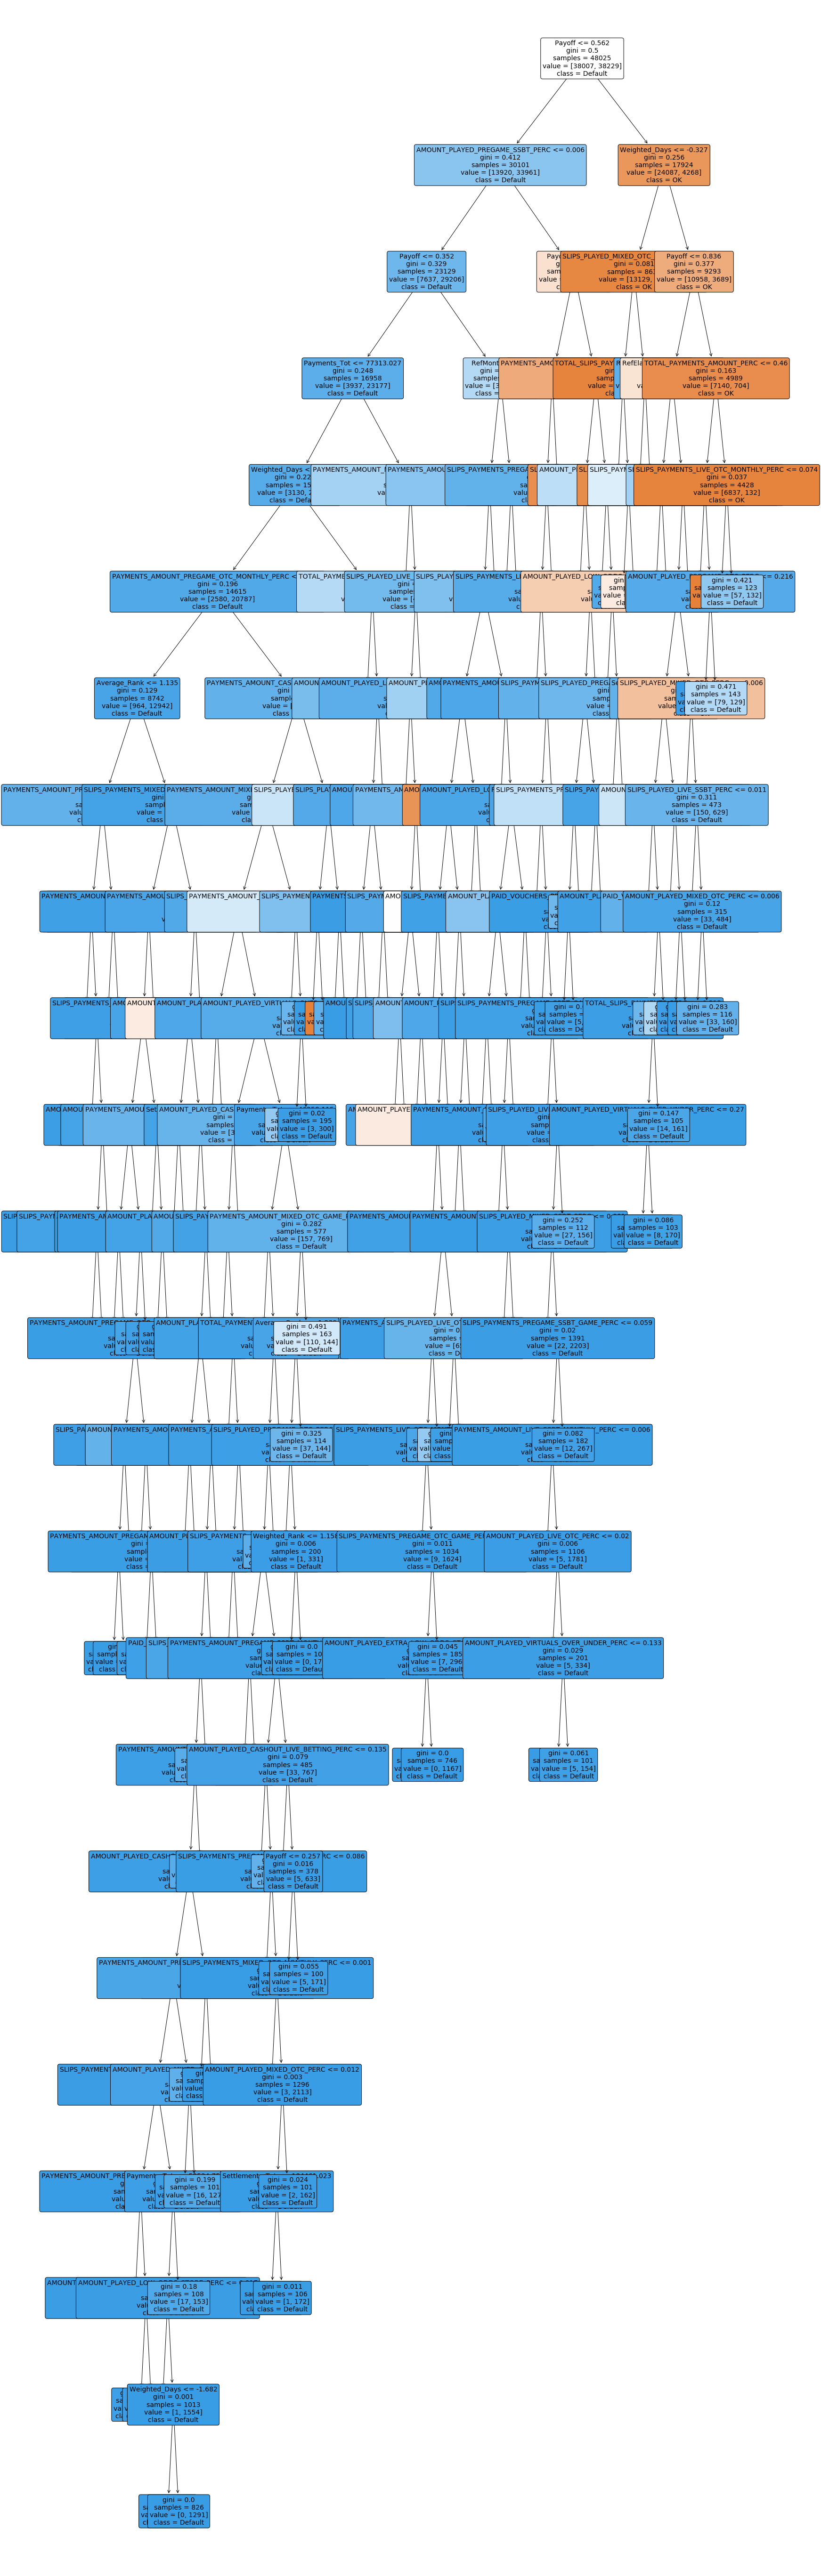

In [28]:
from sklearn import tree
plt.figure(figsize=(25,100))
treemodel = m.estimators_[0]
a = tree.plot_tree(treemodel, 
              feature_names=X.columns, 
              class_names=["OK","Default"],
              filled=True, 
              rounded=True, 
              fontsize=14)

Multiple runs with different parameters

In [178]:
#Initialize metrics
scoring_funcs = {}
scoring_names = ['Precision', 'Recall', 'Accuracy', 'f1 score']
scoring_funcs['Precision'] = precision_score
scoring_funcs['Recall'] = recall_score
scoring_funcs['Accuracy'] = accuracy_score
scoring_funcs['f1 score'] = f1_score
train_scores = {}
valid_scores = {}

for score_key in scoring_names:
    train_scores[score_key]=[]
    valid_scores[score_key]=[]

param_values = []
conf_matrices = []

In [179]:
param_name = "Max features"

for maxfeatures in [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0]:
    min_samples_leaf = int(15*(1.1-maxfeatures))
    print("maxfeatures: ", maxfeatures, "min_samples_leaf: ",min_samples_leaf)
    param_values.append(maxfeatures)
    m = fit(max_features=maxfeatures, min_samples_leaf=min_samples_leaf, n_estimators=200, class_weight=class_weight, X=X_train)
    preds_train = m.predict(X_train)
    preds_valid = m.predict(X_valid)
    for score_key in scoring_names:        
        score = scoring_funcs[score_key](y_train, preds_train)
        train_scores[score_key].append(score)        
        score = scoring_funcs[score_key](y_valid, preds_valid)
        valid_scores[score_key].append(score)
        
    conf_matrix = confusion_matrix(y_valid, preds_valid)
    conf_matrices.append(conf_matrix)
    print(conf_matrix)
    print('----------')

maxfeatures:  0.1 min_samples_leaf:  15
[[7377  191]
 [   7   44]]
----------
maxfeatures:  0.2 min_samples_leaf:  13
[[7450  118]
 [   9   42]]
----------
maxfeatures:  0.3 min_samples_leaf:  12
[[7509   59]
 [  13   38]]
----------
maxfeatures:  0.5 min_samples_leaf:  9
[[7536   32]
 [  22   29]]
----------
maxfeatures:  0.7 min_samples_leaf:  6
[[7557   11]
 [  33   18]]
----------
maxfeatures:  0.9 min_samples_leaf:  3
[[7565    3]
 [  38   13]]
----------
maxfeatures:  1.0 min_samples_leaf:  1
[[7568    0]
 [  41   10]]
----------


In [142]:
param_name = "Min samples leaf"

for minsamples in [25, 50, 75, 100]:
    print(minsamples)
    param_values.append(minsamples)
    m = fit(min_samples_leaf=minsamples, max_features=0.2, n_estimators=100)
    preds_train = m.predict(X_train)
    preds_valid = m.predict(X_valid)
    for score_key in scoring_names:
        score = scoring_funcs[score_key](y_train, preds_train)
        train_scores[score_key].append(score)        
        score = scoring_funcs[score_key](y_valid, preds_valid)
        valid_scores[score_key].append(score)
        
    conf_matrix = confusion_matrix(y_valid, preds_valid)
    conf_matrices.append(conf_matrix)
    print(conf_matrix)
    print('----------')

25


ValueError: Number of features of the model must match the input. Model n_features is 74 and input n_features is 13 

In [674]:
param_name = "Min samples leaf"

for minsamples in [25, 50, 75, 100]:
    print(minsamples)
    param_values.append(minsamples)
    m = fit(min_samples_leaf=minsamples, max_features=0.5, n_estimators=100, max_samples=0.5)
    preds_train = m.predict(X_train)
    preds_valid = m.predict(X_valid)
    for score_key in scoring_names:
        score = scoring_funcs[score_key](y_train, preds_train)
        train_scores[score_key].append(score)        
        score = scoring_funcs[score_key](y_valid, preds_valid)
        valid_scores[score_key].append(score)
        
    conf_matrix = confusion_matrix(y_valid, preds_valid)
    conf_matrices.append(conf_matrix)
    print(conf_matrix)
    print('----------')

25
[[7444  124]
 [  26   25]]
----------
50
[[7250  318]
 [  11   40]]
----------
75
[[7139  429]
 [   8   43]]
----------
100
[[7098  470]
 [   5   46]]
----------


In [342]:
param_name = "Max samples"

for maxsamples in [0.2, 0.3, 0.5, 0.75, 0.99]:
    print(maxsamples)    
    m = fit(min_samples_leaf=50, max_features=0.5, n_estimators=100, max_samples=maxsamples)
    param_values.append(maxsamples)
    preds_train = m.predict(X_train)
    preds_valid = m.predict(X_valid)
    for score_key in scoring_names:
        score = scoring_funcs[score_key](y_train, preds_train)
        train_scores[score_key].append(score)        
        score = scoring_funcs[score_key](y_valid, preds_valid)
        valid_scores[score_key].append(score)
        
    conf_matrix = confusion_matrix(y_valid, preds_valid)
    conf_matrices.append(conf_matrix)
    print(conf_matrix)
    print('----------')

0.2
[[7423  145]
 [  36   15]]
----------
0.3
[[7427  141]
 [  34   17]]
----------
0.5
[[7409  159]
 [  33   18]]
----------
0.75
[[7395  173]
 [  31   20]]
----------
0.99
[[7406  162]
 [  30   21]]
----------


Max features improves precision (decreases false positives). The best value is 0.5 (checked with min_samples_leaf=25)

Min samples leaf is a tradeoff between precision and recall. Low Min samples leaf (=10) has high precision and low recall. High Min samples leaf (=100) has low precision and high recall. Optimal value = 10

Max samples is a tradeoff between precision and recall. Low max samples (=0.05) has low precision and high recall. High max samples (=0.99) has high precision and low recall. Optimal value = 0.2


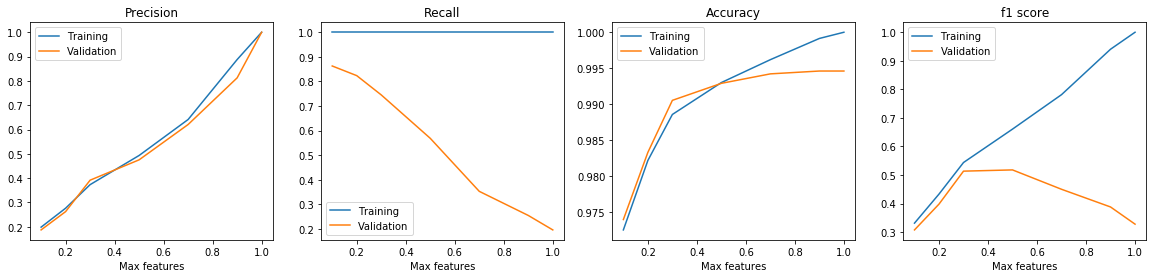

Max features: 0.1 --->
Precision: 0.19, Recall: 0.86
[[7377  191]
 [   7   44]]
Max features: 0.2 --->
Precision: 0.26, Recall: 0.82
[[7450  118]
 [   9   42]]
Max features: 0.3 --->
Precision: 0.39, Recall: 0.75
[[7509   59]
 [  13   38]]
Max features: 0.5 --->
Precision: 0.48, Recall: 0.57
[[7536   32]
 [  22   29]]
Max features: 0.7 --->
Precision: 0.62, Recall: 0.35
[[7557   11]
 [  33   18]]
Max features: 0.9 --->
Precision: 0.81, Recall: 0.25
[[7565    3]
 [  38   13]]
Max features: 1.0 --->
Precision: 1.00, Recall: 0.20
[[7568    0]
 [  41   10]]


In [180]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

i = 0
for score_key in scoring_names:
    axes[i].set_title(scoring_names[i])
    axes[i].plot(param_values, train_scores[score_key], label="Training")
    axes[i].plot(param_values, valid_scores[score_key], label="Validation")
    axes[i].set_xlabel(param_name)
    axes[i].legend()
    i+=1

plt.show()

i=0
for cm in conf_matrices:
    print(f'{param_name}: {param_values[i]} --->')
    print(f'Precision: {valid_scores["Precision"][i]:.2f}, Recall: {valid_scores["Recall"][i]:.2f}')
    print(cm)
    i+=1

In [34]:
preds_valid = m.predict()

500

9.210340371976182

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

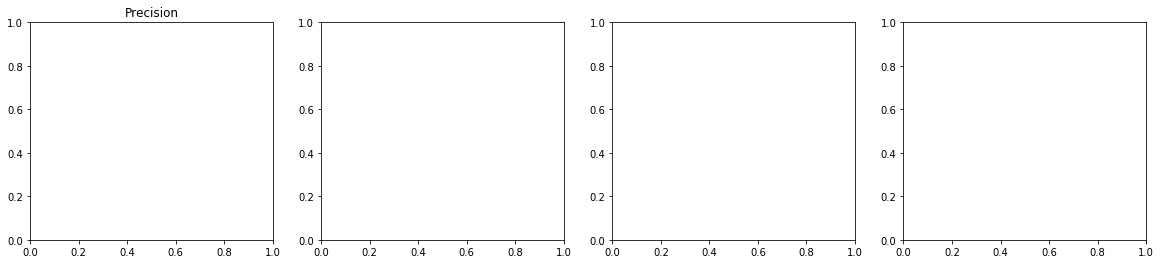

In [863]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

i = 0
for score_key in scoring_names:
    axes[i].set_title(scoring_names[i])
    axes[i].plot(param_values, train_scores[score_key], label="Training")
    axes[i].plot(param_values, valid_scores[score_key], label="Validation")
    axes[i].set_xlabel(param_name)
    axes[i].legend()
    i+=1

plt.show()

i=0
for cm in conf_matrices:
    print(f'{param_name}: {param_values[i]} --->')
    print(f'Precision: {valid_scores["Precision"][i]:.2f}, Recall: {valid_scores["Recall"][i]:.2f}')
    print(cm)
    i+=1
    

# LightGBM

In [9]:
import lightgbm as lgb
#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
#https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [12]:
d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_valid, label=y_valid)
params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'

params['metric'] = 'binary_error'

params['scale_pos_weight'] = 1/unbalanced_ratio

#Will randomly select part of features on each iteration (tree) if feature_fraction smaller than 1.0. 
#For example, if you set it to 0.8, LightGBM will select 80% of features before training each tree
params['feature_fraction'] = 0.5

#Max number of leaves in one tree, default = 31
params['num_leaves'] = 14

#Minimal number of data in one leaf. Can be used to deal with over-fitting
params['min_data_in_leaf'] = 50

#Limit the max depth for tree model. This is used to deal with over-fitting when #data is small. 
#Tree still grows leaf-wise
#<= 0 means no limit, default = -1, type = int
#params['max_depth'] = 100

params['bagging_fraction'] = 0.8
params['bagging_freq'] = 2

params['lambdarank_norm'] = True

#params['is_unbalance'] = True

clf = lgb.train(params, d_train, num_boost_round=2000, valid_sets=d_valid, valid_names='Validation')

[1]	Validation's binary_error: 0.00669379
[2]	Validation's binary_error: 0.00669379
[3]	Validation's binary_error: 0.00669379
[4]	Validation's binary_error: 0.00669379
[5]	Validation's binary_error: 0.00669379
[6]	Validation's binary_error: 0.00669379
[7]	Validation's binary_error: 0.00669379
[8]	Validation's binary_error: 0.00669379
[9]	Validation's binary_error: 0.00669379
[10]	Validation's binary_error: 0.00669379
[11]	Validation's binary_error: 0.00669379
[12]	Validation's binary_error: 0.00669379
[13]	Validation's binary_error: 0.00669379
[14]	Validation's binary_error: 0.00669379
[15]	Validation's binary_error: 0.00669379
[16]	Validation's binary_error: 0.00669379
[17]	Validation's binary_error: 0.00669379
[18]	Validation's binary_error: 0.00669379
[19]	Validation's binary_error: 0.00669379
[20]	Validation's binary_error: 0.00669379
[21]	Validation's binary_error: 0.00669379
[22]	Validation's binary_error: 0.00669379
[23]	Validation's binary_error: 0.00669379
[24]	Validation's bi

[219]	Validation's binary_error: 0.0577504
[220]	Validation's binary_error: 0.0580129
[221]	Validation's binary_error: 0.0580129
[222]	Validation's binary_error: 0.0580129
[223]	Validation's binary_error: 0.0578816
[224]	Validation's binary_error: 0.0582754
[225]	Validation's binary_error: 0.0582754
[226]	Validation's binary_error: 0.0585379
[227]	Validation's binary_error: 0.0586691
[228]	Validation's binary_error: 0.0586691
[229]	Validation's binary_error: 0.0589316
[230]	Validation's binary_error: 0.0590629
[231]	Validation's binary_error: 0.0591941
[232]	Validation's binary_error: 0.0594566
[233]	Validation's binary_error: 0.0594566
[234]	Validation's binary_error: 0.0595879
[235]	Validation's binary_error: 0.0595879
[236]	Validation's binary_error: 0.0598504
[237]	Validation's binary_error: 0.0597191
[238]	Validation's binary_error: 0.0597191
[239]	Validation's binary_error: 0.0602441
[240]	Validation's binary_error: 0.0605066
[241]	Validation's binary_error: 0.0598504
[242]	Valid

[438]	Validation's binary_error: 0.0568316
[439]	Validation's binary_error: 0.0570941
[440]	Validation's binary_error: 0.0569629
[441]	Validation's binary_error: 0.0568316
[442]	Validation's binary_error: 0.0567004
[443]	Validation's binary_error: 0.0565691
[444]	Validation's binary_error: 0.0565691
[445]	Validation's binary_error: 0.0565691
[446]	Validation's binary_error: 0.0567004
[447]	Validation's binary_error: 0.0567004
[448]	Validation's binary_error: 0.0568316
[449]	Validation's binary_error: 0.0567004
[450]	Validation's binary_error: 0.0565691
[451]	Validation's binary_error: 0.0565691
[452]	Validation's binary_error: 0.0564379
[453]	Validation's binary_error: 0.0563066
[454]	Validation's binary_error: 0.0563066
[455]	Validation's binary_error: 0.0563066
[456]	Validation's binary_error: 0.0567004
[457]	Validation's binary_error: 0.0568316
[458]	Validation's binary_error: 0.0564379
[459]	Validation's binary_error: 0.0564379
[460]	Validation's binary_error: 0.0563066
[461]	Valid

[647]	Validation's binary_error: 0.045019
[648]	Validation's binary_error: 0.0448878
[649]	Validation's binary_error: 0.0448878
[650]	Validation's binary_error: 0.045019
[651]	Validation's binary_error: 0.045019
[652]	Validation's binary_error: 0.045019
[653]	Validation's binary_error: 0.045019
[654]	Validation's binary_error: 0.0447565
[655]	Validation's binary_error: 0.0447565
[656]	Validation's binary_error: 0.0447565
[657]	Validation's binary_error: 0.0447565
[658]	Validation's binary_error: 0.0446253
[659]	Validation's binary_error: 0.0446253
[660]	Validation's binary_error: 0.0447565
[661]	Validation's binary_error: 0.0446253
[662]	Validation's binary_error: 0.044494
[663]	Validation's binary_error: 0.044494
[664]	Validation's binary_error: 0.044494
[665]	Validation's binary_error: 0.044494
[666]	Validation's binary_error: 0.0443628
[667]	Validation's binary_error: 0.0443628
[668]	Validation's binary_error: 0.0443628
[669]	Validation's binary_error: 0.0443628
[670]	Validation's b

[857]	Validation's binary_error: 0.0364877
[858]	Validation's binary_error: 0.036619
[859]	Validation's binary_error: 0.0367502
[860]	Validation's binary_error: 0.0364877
[861]	Validation's binary_error: 0.0364877
[862]	Validation's binary_error: 0.0364877
[863]	Validation's binary_error: 0.0364877
[864]	Validation's binary_error: 0.036619
[865]	Validation's binary_error: 0.036619
[866]	Validation's binary_error: 0.0364877
[867]	Validation's binary_error: 0.0364877
[868]	Validation's binary_error: 0.0363565
[869]	Validation's binary_error: 0.0363565
[870]	Validation's binary_error: 0.0362252
[871]	Validation's binary_error: 0.0362252
[872]	Validation's binary_error: 0.0362252
[873]	Validation's binary_error: 0.036094
[874]	Validation's binary_error: 0.036094
[875]	Validation's binary_error: 0.036094
[876]	Validation's binary_error: 0.036094
[877]	Validation's binary_error: 0.0359627
[878]	Validation's binary_error: 0.0359627
[879]	Validation's binary_error: 0.0358315
[880]	Validation's

[1050]	Validation's binary_error: 0.0326815
[1051]	Validation's binary_error: 0.0321565
[1052]	Validation's binary_error: 0.0321565
[1053]	Validation's binary_error: 0.0320252
[1054]	Validation's binary_error: 0.0321565
[1055]	Validation's binary_error: 0.0320252
[1056]	Validation's binary_error: 0.0320252
[1057]	Validation's binary_error: 0.0320252
[1058]	Validation's binary_error: 0.0320252
[1059]	Validation's binary_error: 0.0320252
[1060]	Validation's binary_error: 0.0320252
[1061]	Validation's binary_error: 0.0320252
[1062]	Validation's binary_error: 0.0320252
[1063]	Validation's binary_error: 0.0318939
[1064]	Validation's binary_error: 0.0315002
[1065]	Validation's binary_error: 0.0315002
[1066]	Validation's binary_error: 0.0317627
[1067]	Validation's binary_error: 0.0315002
[1068]	Validation's binary_error: 0.0315002
[1069]	Validation's binary_error: 0.0315002
[1070]	Validation's binary_error: 0.0313689
[1071]	Validation's binary_error: 0.0321565
[1072]	Validation's binary_error

[1253]	Validation's binary_error: 0.0263814
[1254]	Validation's binary_error: 0.0263814
[1255]	Validation's binary_error: 0.0263814
[1256]	Validation's binary_error: 0.0263814
[1257]	Validation's binary_error: 0.0263814
[1258]	Validation's binary_error: 0.0262502
[1259]	Validation's binary_error: 0.0262502
[1260]	Validation's binary_error: 0.0262502
[1261]	Validation's binary_error: 0.0261189
[1262]	Validation's binary_error: 0.0259877
[1263]	Validation's binary_error: 0.0259877
[1264]	Validation's binary_error: 0.0261189
[1265]	Validation's binary_error: 0.0261189
[1266]	Validation's binary_error: 0.0259877
[1267]	Validation's binary_error: 0.0259877
[1268]	Validation's binary_error: 0.0261189
[1269]	Validation's binary_error: 0.0261189
[1270]	Validation's binary_error: 0.0261189
[1271]	Validation's binary_error: 0.0258564
[1272]	Validation's binary_error: 0.0258564
[1273]	Validation's binary_error: 0.0258564
[1274]	Validation's binary_error: 0.0258564
[1275]	Validation's binary_error

[1469]	Validation's binary_error: 0.0215251
[1470]	Validation's binary_error: 0.0215251
[1471]	Validation's binary_error: 0.0215251
[1472]	Validation's binary_error: 0.0215251
[1473]	Validation's binary_error: 0.0215251
[1474]	Validation's binary_error: 0.0215251
[1475]	Validation's binary_error: 0.0215251
[1476]	Validation's binary_error: 0.0215251
[1477]	Validation's binary_error: 0.0215251
[1478]	Validation's binary_error: 0.0215251
[1479]	Validation's binary_error: 0.0215251
[1480]	Validation's binary_error: 0.0215251
[1481]	Validation's binary_error: 0.0215251
[1482]	Validation's binary_error: 0.0215251
[1483]	Validation's binary_error: 0.0215251
[1484]	Validation's binary_error: 0.0215251
[1485]	Validation's binary_error: 0.0215251
[1486]	Validation's binary_error: 0.0215251
[1487]	Validation's binary_error: 0.0215251
[1488]	Validation's binary_error: 0.0215251
[1489]	Validation's binary_error: 0.0215251
[1490]	Validation's binary_error: 0.0215251
[1491]	Validation's binary_error

[1679]	Validation's binary_error: 0.0195564
[1680]	Validation's binary_error: 0.0195564
[1681]	Validation's binary_error: 0.0195564
[1682]	Validation's binary_error: 0.0195564
[1683]	Validation's binary_error: 0.0195564
[1684]	Validation's binary_error: 0.0195564
[1685]	Validation's binary_error: 0.0195564
[1686]	Validation's binary_error: 0.0195564
[1687]	Validation's binary_error: 0.0195564
[1688]	Validation's binary_error: 0.0195564
[1689]	Validation's binary_error: 0.0195564
[1690]	Validation's binary_error: 0.0195564
[1691]	Validation's binary_error: 0.0195564
[1692]	Validation's binary_error: 0.0195564
[1693]	Validation's binary_error: 0.0195564
[1694]	Validation's binary_error: 0.0194251
[1695]	Validation's binary_error: 0.0194251
[1696]	Validation's binary_error: 0.0194251
[1697]	Validation's binary_error: 0.0194251
[1698]	Validation's binary_error: 0.0192939
[1699]	Validation's binary_error: 0.0191626
[1700]	Validation's binary_error: 0.0191626
[1701]	Validation's binary_error

[1866]	Validation's binary_error: 0.0164064
[1867]	Validation's binary_error: 0.0164064
[1868]	Validation's binary_error: 0.0164064
[1869]	Validation's binary_error: 0.0164064
[1870]	Validation's binary_error: 0.0164064
[1871]	Validation's binary_error: 0.0164064
[1872]	Validation's binary_error: 0.0164064
[1873]	Validation's binary_error: 0.0164064
[1874]	Validation's binary_error: 0.0164064
[1875]	Validation's binary_error: 0.0164064
[1876]	Validation's binary_error: 0.0164064
[1877]	Validation's binary_error: 0.0164064
[1878]	Validation's binary_error: 0.0164064
[1879]	Validation's binary_error: 0.0164064
[1880]	Validation's binary_error: 0.0164064
[1881]	Validation's binary_error: 0.0164064
[1882]	Validation's binary_error: 0.0164064
[1883]	Validation's binary_error: 0.0168001
[1884]	Validation's binary_error: 0.0168001
[1885]	Validation's binary_error: 0.0166689
[1886]	Validation's binary_error: 0.0162751
[1887]	Validation's binary_error: 0.0162751
[1888]	Validation's binary_error

In [21]:
#Prediction
threshold = 0.80
preds=clf.predict(X_valid)
preds = preds>threshold

In [22]:
confusion_matrix(y_valid, preds)

array([[7522,   46],
       [  23,   28]], dtype=int64)

In [15]:
y_valid.shape

(7619,)

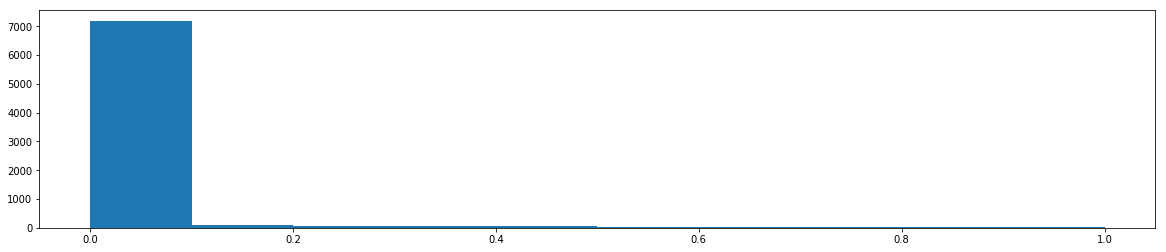

In [16]:
preds=clf.predict(X_valid)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))

ax.hist(preds, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()

In [17]:
preds = preds>threshold
print(f'Precision: {precision_score(y_valid,preds)}, Recall: {recall_score(y_valid,preds)}')
mistakes = X_valid.copy()
mistakes['label'] = y_valid
mistakes['prediction'] = preds
mistakes = mistakes[preds!=y_valid]
print(f'Mistakes: {len(mistakes)}')
print(f'False negatives: {mistakes.query("label==1").count()["prediction"]}')

Precision: 0.3384615384615385, Recall: 0.8627450980392157
Mistakes: 93
False negatives: 7


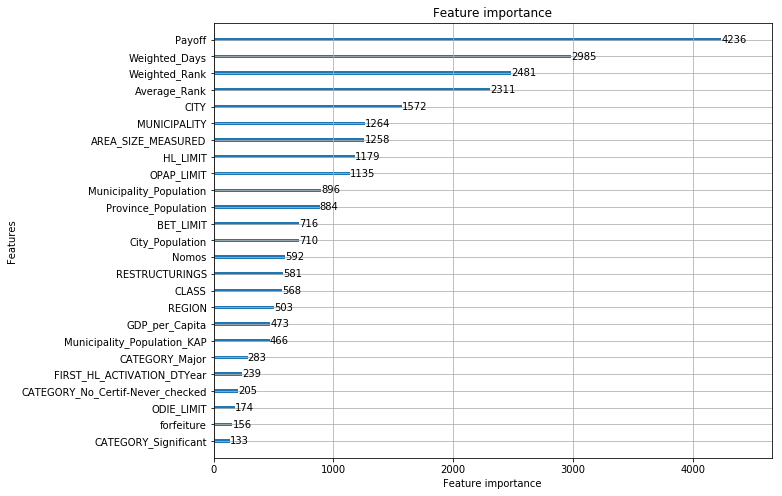

In [18]:
lgb.plot_importance(clf, max_num_features=25, figsize=(10,8))

In [889]:
scoring_funcs = {}
scoring_names = ['Precision', 'Recall', 'Accuracy', 'f1 score']
scoring_funcs['Precision'] = precision_score
scoring_funcs['Recall'] = recall_score
scoring_funcs['Accuracy'] = accuracy_score
scoring_funcs['f1 score'] = f1_score
train_scores = {}
valid_scores = {}

for score_key in scoring_names:
    train_scores[score_key]=[]
    valid_scores[score_key]=[]

param_values = []
conf_matrices = []

param_name = "Learning rate"    

for lr in [0.005, 0.01, 0.02, 0.03, 0.04, 0.05]:
    params['learning_rate'] = lr
    clf = lgb.train(params, d_train, 100, valid_sets=d_valid, valid_names='Validation')
    param_values.append(lr)
           
    preds_train = clf.predict(X_train)
    preds_valid = clf.predict(X_valid)
    preds_train = preds_train>0.5
    preds_valid = preds_valid>0.5
    
    for score_key in scoring_names:
        score = scoring_funcs[score_key](y_train, preds_train)
        train_scores[score_key].append(score)        
        score = scoring_funcs[score_key](y_valid, preds_valid)
        valid_scores[score_key].append(score)
        
    conf_matrix = confusion_matrix(y_valid, preds_valid)
    conf_matrices.append(conf_matrix)

[1]	Validation's binary_error: 0.00669379
[2]	Validation's binary_error: 0.00669379
[3]	Validation's binary_error: 0.00669379
[4]	Validation's binary_error: 0.00669379
[5]	Validation's binary_error: 0.00669379
[6]	Validation's binary_error: 0.00669379
[7]	Validation's binary_error: 0.00669379
[8]	Validation's binary_error: 0.00669379
[9]	Validation's binary_error: 0.00669379
[10]	Validation's binary_error: 0.00669379
[11]	Validation's binary_error: 0.00669379
[12]	Validation's binary_error: 0.00669379
[13]	Validation's binary_error: 0.00669379
[14]	Validation's binary_error: 0.00669379
[15]	Validation's binary_error: 0.00669379
[16]	Validation's binary_error: 0.00669379
[17]	Validation's binary_error: 0.00669379
[18]	Validation's binary_error: 0.00669379
[19]	Validation's binary_error: 0.00669379
[20]	Validation's binary_error: 0.00669379
[21]	Validation's binary_error: 0.00669379
[22]	Validation's binary_error: 0.00669379
[23]	Validation's binary_error: 0.00669379
[24]	Validation's bi

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1]	Validation's binary_error: 0.00669379
[2]	Validation's binary_error: 0.00669379
[3]	Validation's binary_error: 0.00669379
[4]	Validation's binary_error: 0.00669379
[5]	Validation's binary_error: 0.00669379
[6]	Validation's binary_error: 0.00669379
[7]	Validation's binary_error: 0.00669379
[8]	Validation's binary_error: 0.00669379
[9]	Validation's binary_error: 0.00669379
[10]	Validation's binary_error: 0.00669379
[11]	Validation's binary_error: 0.00669379
[12]	Validation's binary_error: 0.00669379
[13]	Validation's binary_error: 0.00669379
[14]	Validation's binary_error: 0.00669379
[15]	Validation's binary_error: 0.00669379
[16]	Validation's binary_error: 0.00669379
[17]	Validation's binary_error: 0.00669379
[18]	Validation's binary_error: 0.00669379
[19]	Validation's binary_error: 0.00669379
[20]	Validation's binary_error: 0.00669379
[21]	Validation's binary_error: 0.00669379
[22]	Validation's binary_error: 0.00669379
[23]	Validation's binary_error: 0.00669379
[24]	Validation's bi

[1]	Validation's binary_error: 0.00669379
[2]	Validation's binary_error: 0.00708754
[3]	Validation's binary_error: 0.00708754
[4]	Validation's binary_error: 0.00708754
[5]	Validation's binary_error: 0.0072188
[6]	Validation's binary_error: 0.00735005
[7]	Validation's binary_error: 0.0074813
[8]	Validation's binary_error: 0.0074813
[9]	Validation's binary_error: 0.0087938
[10]	Validation's binary_error: 0.00892506
[11]	Validation's binary_error: 0.00971256
[12]	Validation's binary_error: 0.0105001
[13]	Validation's binary_error: 0.0108938
[14]	Validation's binary_error: 0.0157501
[15]	Validation's binary_error: 0.0187689
[16]	Validation's binary_error: 0.0233626
[17]	Validation's binary_error: 0.0255939
[18]	Validation's binary_error: 0.0280877
[19]	Validation's binary_error: 0.0308439
[20]	Validation's binary_error: 0.0320252
[21]	Validation's binary_error: 0.0337315
[22]	Validation's binary_error: 0.0362252
[23]	Validation's binary_error: 0.0378002
[24]	Validation's binary_error: 0.03

[1]	Validation's binary_error: 0.377084
[2]	Validation's binary_error: 0.381152
[3]	Validation's binary_error: 0.381809
[4]	Validation's binary_error: 0.38194
[5]	Validation's binary_error: 0.321433
[6]	Validation's binary_error: 0.320252
[7]	Validation's binary_error: 0.341908
[8]	Validation's binary_error: 0.292296
[9]	Validation's binary_error: 0.303321
[10]	Validation's binary_error: 0.293083
[11]	Validation's binary_error: 0.313558
[12]	Validation's binary_error: 0.325896
[13]	Validation's binary_error: 0.290327
[14]	Validation's binary_error: 0.269852
[15]	Validation's binary_error: 0.270377
[16]	Validation's binary_error: 0.235333
[17]	Validation's binary_error: 0.232839
[18]	Validation's binary_error: 0.210001
[19]	Validation's binary_error: 0.207376
[20]	Validation's binary_error: 0.206851
[21]	Validation's binary_error: 0.21092
[22]	Validation's binary_error: 0.195564
[23]	Validation's binary_error: 0.194645
[24]	Validation's binary_error: 0.195695
[25]	Validation's binary_er

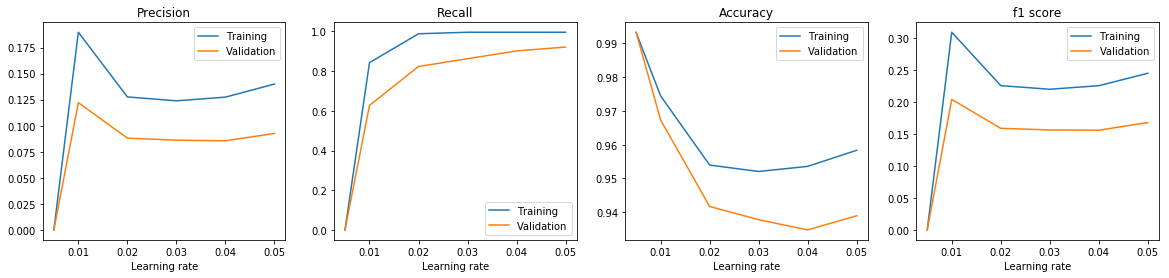

Learning rate: 0.005 --->
Precision: 0.00, Recall: 0.00
[[7568    0]
 [  51    0]]
Learning rate: 0.01 --->
Precision: 0.12, Recall: 0.63
[[7338  230]
 [  19   32]]
Learning rate: 0.02 --->
Precision: 0.09, Recall: 0.82
[[7133  435]
 [   9   42]]
Learning rate: 0.03 --->
Precision: 0.09, Recall: 0.86
[[7101  467]
 [   7   44]]
Learning rate: 0.04 --->
Precision: 0.09, Recall: 0.90
[[7076  492]
 [   5   46]]
Learning rate: 0.05 --->
Precision: 0.09, Recall: 0.92
[[7107  461]
 [   4   47]]


In [890]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

i = 0
for score_key in scoring_names:
    axes[i].set_title(scoring_names[i])
    axes[i].plot(param_values, train_scores[score_key], label="Training")
    axes[i].plot(param_values, valid_scores[score_key], label="Validation")
    axes[i].set_xlabel(param_name)
    axes[i].legend()
    i+=1

plt.show()

i=0
for cm in conf_matrices:
    print(f'{param_name}: {param_values[i]} --->')
    print(f'Precision: {valid_scores["Precision"][i]:.2f}, Recall: {valid_scores["Recall"][i]:.2f}')
    print(cm)
    i+=1

# Correlation

In [412]:
pd.DataFrame(sorted(zip(clf.feature_importance(), X_train.columns)), columns=['Value','Feature']).sort_values(by='Value', ascending=False)

,Value,Feature
26,2274,Payments_Tot
25,2129,Payoff
24,1999,Settlements_Tot
23,1643,Weighted_Days
22,1197,Average_Rank
21,1152,Weighted_Rank
20,887,CITY
19,796,MUNICIPALITY
18,769,HL_LIMIT
17,716,OPAP_LIMIT


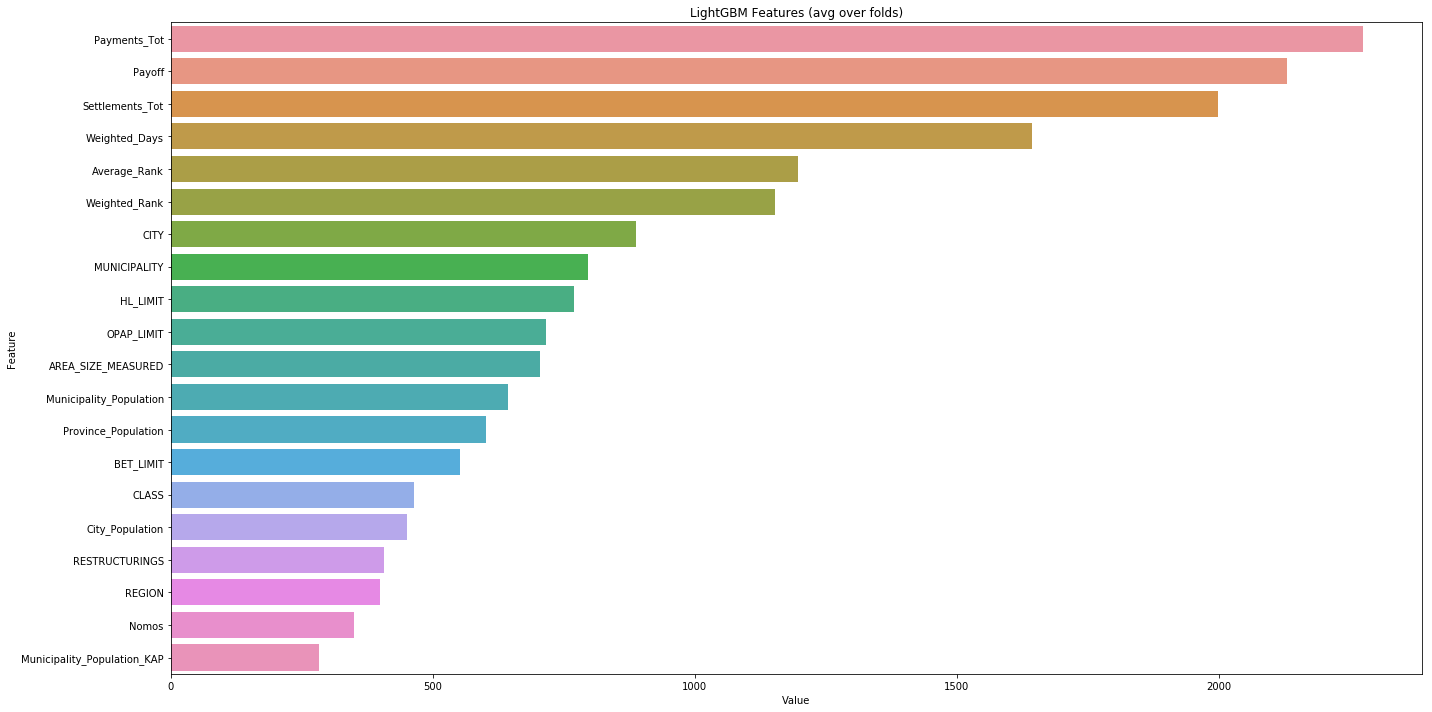

In [415]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),X_train.columns)), columns=['Value','Feature']) \
    .sort_values(by='Value', ascending=False).head(20)
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [909]:
cols_to_keep = feature_imp.query("Value>10")['Feature']
cols_to_keep

48     AMOUNT_PLAYED_EXTRA_LOW_ODDS_STORE_PERC
49                AMOUNT_PLAYED_MIXED_OTC_PERC
50    PAYMENTS_AMOUNT_PREGAME_OTC_MONTHLY_PERC
51                 SLIPS_PAYMENTS_CASHOUT_PERC
52      PAYMENTS_AMOUNT_LIVE_SSBT_MONTHLY_PERC
53          SLIPS_PAYMENTS_MIXED_OTC_GAME_PERC
54       SLIPS_PAYMENTS_MIXED_OTC_MONTHLY_PERC
55      SLIPS_PAYMENTS_MIXED_SSBT_MONTHLY_PERC
56                 AMOUNT_PLAYED_LIVE_OTC_PERC
57     AMOUNT_PLAYED_CASHOUT_LIVE_BETTING_PERC
58     AMOUNT_PLAYED_EXTRA_LOW_ODDS_TOTAL_PERC
59                               Weighted_Rank
60                  TOTAL_PAYMENTS_AMOUNT_PERC
61      AMOUNT_PLAYED_VIRTUALS_OVER_UNDER_PERC
62                                Average_Rank
63                  SLIPS_PLAYED_LIVE_OTC_PERC
64              AMOUNT_PLAYED_PREGAME_OTC_PERC
65                               Weighted_Days
66      PAYMENTS_AMOUNT_MIXED_OTC_MONTHLY_PERC
67                                    RefMonth
68           SLIPS_PAYMENTS_LIVE_OTC_GAME_PERC
69           

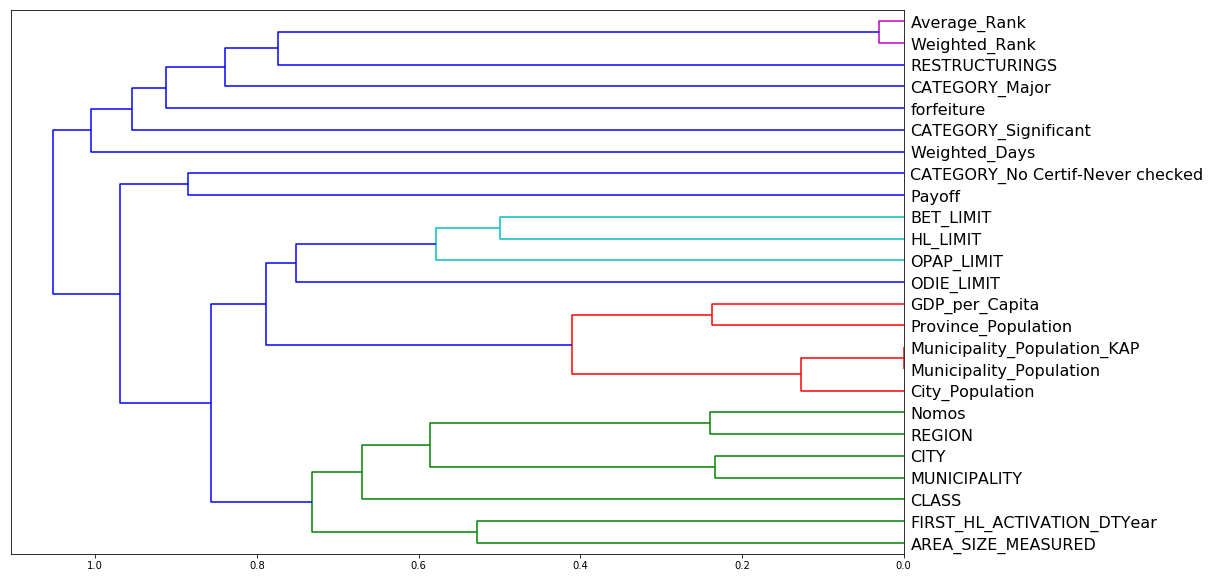

In [535]:
df_keep = X_train
import scipy
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()